In [101]:
import torch
import math
import string

from torch_geometric.data import Data
from torch_geometric.utils import is_undirected, to_undirected
from torch_geometric.loader import DataLoader
from torch.nn import Module
from scipy.stats import ortho_group
from typing import List, Optional

from src.utils.plot_utils import plot_2d, plot_3d
from cartesian_mace.utils.cartesian_contractions import e_rbf, create_zero_feature_tensors, tensor_prod
from cartesian_mace.modules.atomic_basis_block import AtomicBasis
from cartesian_mace.modules.weighted_sum_block import WeightedSum
from cartesian_mace.models.model import CartesianMACE

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
# now create a random rotation
def random_orthogonal_matrix(dim=3):
  Q = torch.tensor(ortho_group.rvs(dim=dim)).float()
  return Q

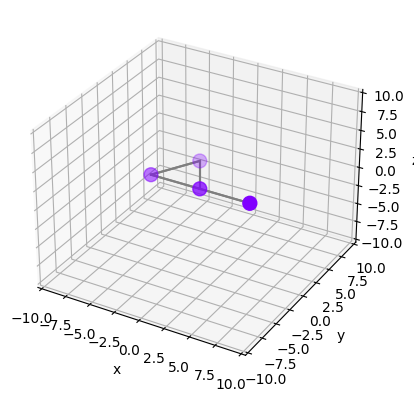

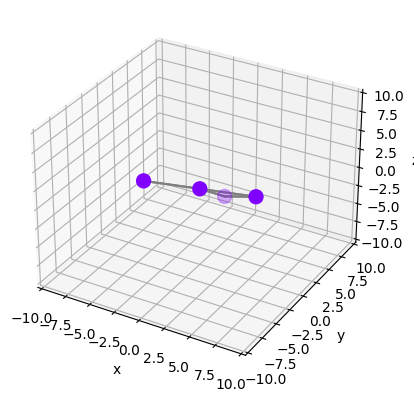

In [103]:
# first define a neighbourhood in 3d dimensions for a simple molecule

# create very simple, first non-trivial graph
atoms = torch.ones(4, 1, dtype=torch.long).long()
edge_index = torch.LongTensor([[0, 0, 1, 2], [1, 2, 2, 3]])
edge_index = to_undirected(edge_index)
pos = 5 * torch.Tensor([[0, 0, 0], [0.5, math.sqrt(3) * 0.5, 0], [1, 0, 0], [2, 0, 0]]) - torch.Tensor([5, 0, 0])
y = torch.Tensor([0])  # label

data = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
# dataloader = DataLoader(data, data_size=1, shuffle=True)

plot_3d(data)

Q = random_orthogonal_matrix()

data.pos = data.pos @ Q.T

plot_3d(data)

In [104]:
# define some hyperparameters
basis_rank_max=2
self_tp_rank_max=2
n_channels=1
n_edges=len(data.edge_index[0])
n_nodes=len(data.atoms)
dim=3
feature_rank_max=2
nu_max=4

In [105]:
rel_pos = data.pos[data.edge_index[0]] - data.pos[data.edge_index[1]]
dists = torch.linalg.norm(rel_pos, dim=-1)
norm_rel_pos = rel_pos / dists.reshape(-1, 1)

r_tensors = [
    tensor_prod(r=norm_rel_pos, order=rank)
    for rank in range(0, self_tp_rank_max + 1)
]

n_values = torch.arange(1, n_channels + 1).unsqueeze(1)
# why are all channels the same value ** have a look at this problem
# dists is r_ij where i is edge_index 0 and j is edge_index 1
radial_emb = e_rbf(r=dists, n=n_values).reshape(
    n_edges, n_channels
)

# here we project the self TP tensors along the channel dimension
# in: [n_edges, n_channels] x [n_edges, tensor_shape[tp_rank]]
# out: [n_edges, n_channels, tensor_shape[tp_rank]]
edge_attr = [
    torch.einsum("ij,i...->ij...", radial_emb, r_tensors[tp_rank])
    for tp_rank in range(0, self_tp_rank_max + 1)
]

# we could potentially change this for flattened tensors for speed ?
# create the empty feature tensors
# such that we get a list of length feature_rank + 1 (can't forget scalar features)
# for each rank we get a tensor
# out: [n_nodes, n_channels, tensor_shape]
h = create_zero_feature_tensors(
    feature_rank_max=feature_rank_max,
    n_nodes=n_nodes,
    n_channels=n_channels,
    dim=dim,
    populate=True
)

In [106]:
def transform_tensor(T: torch.Tensor, Q: torch.Tensor, multiple_nodes: Optional[bool] = True, multiple_channels: Optional[bool] = True) -> torch.Tensor:

    # we don't want to transform scalars
    if T.shape[-1] == 1:
        return T

    # find the rank of T
    rank = len(T.shape)  - multiple_nodes - multiple_channels# ignore the n_nodes, n_channels indices

    indices_out = [char for char in string.ascii_lowercase[8:]]
    indices_in = [char for char in string.ascii_lowercase[:8]]


    # einsum in
    einsum_in = ','.join([x + y for x, y in zip(indices_out[:rank], indices_in[:rank])] + [''.join(['...']  + indices_in[:rank])])
    einsum_out = '->...' + ''.join(indices_out[:rank])

    einsum = einsum_in + einsum_out

    # get that many Qs ready
    tensors_in = [Q,] * rank + [T,]

    transformed_tensor = torch.einsum(einsum, *tensors_in)

    return transformed_tensor

In [107]:
def test_block_equivariance(tensors_in: List[torch.Tensor], module: Module, Q: torch.Tensor, **kwargs) -> List[int]:

    # general test for any block

    # rotation before
    tensors_in_rotated = [transform_tensor(T=T, Q=Q) for T in tensors_in]
    tensors_out2 = module(tensors_in_rotated, **kwargs)

    # rotation after
    tensors_out1 = module(tensors_in, **kwargs)
    tensors_out1_rotated = [transform_tensor(T=T, Q=Q) for T in tensors_out1]

    for rank in range(0,len(tensors_out1)):

        # check that the sum of all the errors is zero
        assert torch.allclose(tensors_out1_rotated[rank], tensors_out2[rank], atol=1e-7)

In [108]:
atomic_basis = AtomicBasis(
    basis_rank_max=basis_rank_max,
    self_tp_rank_max=self_tp_rank_max,
    n_channels=n_channels,
    # n_nodes=n_nodes,
    dim=dim,
    # n_edges=n_edges,
    h_rank_max=feature_rank_max, # is this degenerate ?
    )

weighted_sum = WeightedSum(
    nu_max=nu_max,
    c_in_max=basis_rank_max,
    c_out_max=feature_rank_max,
    n_channels=n_channels,
    dim=dim,
    # n_nodes=n_nodes,
    )

cartesian_mace = CartesianMACE(
    n_channels=n_channels,
    self_tp_rank_max=self_tp_rank_max,
    basis_rank_max=basis_rank_max,
    dim=dim,
    n_layers=1,
    nu_max=nu_max,
    feature_rank_max=feature_rank_max,
)

In [109]:
tensors_in

[tensor([[[ 0.4306]],
 
         [[-0.6239]],
 
         [[ 0.0186]],
 
         [[ 0.6943]]]),
 tensor([[[ 0.3624,  0.4537, -1.9891]],
 
         [[ 1.0901,  0.4795,  1.7582]],
 
         [[-1.0645,  0.7187,  1.2550]],
 
         [[-0.3732,  0.4266, -0.0543]]]),
 tensor([[[[-0.7462, -0.3578,  1.9740],
           [ 0.2510,  0.2733, -0.4966],
           [ 0.8906, -0.5740, -0.5125]]],
 
 
         [[[ 0.5553,  0.6197,  1.4525],
           [-0.4652,  1.4675, -1.8423],
           [ 0.4898,  0.7967, -0.6637]]],
 
 
         [[[-1.2560,  1.6667,  0.4836],
           [-2.5933, -0.1078, -0.2876],
           [ 0.1532,  1.5254,  0.8648]]],
 
 
         [[[-0.1787,  0.9966, -1.6608],
           [ 0.6055,  2.1311,  1.8462],
           [ 0.4874, -0.3014,  0.5429]]]])]

In [128]:
tensors_in = h
edge_attr_rotated = [transform_tensor(T=T, Q=Q) for T in edge_attr]

tensors_in_rotated = [transform_tensor(T=T, Q=Q) for T in tensors_in]
tensors_out2 = atomic_basis(tensors_in_rotated, rel_pos, edge_index, edge_attr_rotated)

# rotation after
tensors_out1 = atomic_basis(tensors_in, rel_pos, edge_index, edge_attr)
tensors_out1_rotated = [transform_tensor(T=T, Q=Q) for T in tensors_out1]

for rank in range(0,len(tensors_out1)):
    # check that the sum of all the errors is zero
    assert torch.allclose(tensors_out1_rotated[rank], tensors_out2[rank], atol=1e-8)

In [111]:
tensors_out1_rotated[rank] - tensors_out2[rank]

tensor([[[[ 7.4506e-09,  1.8626e-08, -7.4506e-09],
          [-7.4506e-09,  7.4506e-09,  7.4506e-09],
          [ 0.0000e+00, -2.2352e-08,  0.0000e+00]]],


        [[[ 0.0000e+00, -7.4506e-09,  0.0000e+00],
          [-1.4901e-08, -3.7253e-09, -1.4901e-08],
          [ 0.0000e+00,  7.4506e-09,  4.4703e-08]]],


        [[[ 5.9605e-08,  0.0000e+00,  0.0000e+00],
          [ 2.9802e-08, -7.4506e-09,  2.9802e-08],
          [-5.9605e-08, -2.9802e-08,  5.9605e-08]]],


        [[[ 8.9407e-08,  2.9802e-08,  0.0000e+00],
          [ 2.9802e-08,  1.4901e-08,  0.0000e+00],
          [ 0.0000e+00, -7.4506e-09,  0.0000e+00]]]], grad_fn=<SubBackward0>)

In [137]:
a_set = atomic_basis(h=h, rel_pos=rel_pos, edge_index=edge_index, edge_attr=edge_attr)
a_set[0] = a_set[0].reshape(n_nodes, n_channels, 1)

# rotation before
a_set_rotated = [transform_tensor(T=T, Q=Q) for T in a_set]
tensors_out2 = weighted_sum(a_set_rotated)

# rotation after
tensors_out1 = weighted_sum(a_set)
tensors_out1_rotated = [transform_tensor(T=T, Q=Q) for T in tensors_out1]

for rank in range(0,len(tensors_out1)):
    print(rank)
    # check that the sum of all the errors is zero
    assert torch.allclose(tensors_out1_rotated[rank], tensors_out2[rank], atol=1e-6)

0
1
2


In [138]:
tensors_out1_rotated[rank] - tensors_out2[rank]

tensor([[[[-2.3842e-07, -1.1921e-07,  4.7684e-07],
          [ 5.9605e-08,  4.9174e-07,  9.5367e-07],
          [ 0.0000e+00, -1.3411e-07, -7.1526e-07]]],


        [[[ 8.3447e-07, -2.9802e-07, -5.3644e-07],
          [-1.6391e-07, -2.0862e-07, -7.1526e-07],
          [ 1.2293e-07, -2.0862e-07, -6.3702e-07]]],


        [[[-3.3379e-06, -5.3644e-07, -5.6028e-06],
          [-3.1590e-06,  2.8610e-06, -1.2517e-06],
          [ 3.8147e-06, -1.1921e-07,  4.7684e-07]]],


        [[[ 2.9802e-06,  1.1921e-07,  1.1921e-06],
          [ 7.1526e-07,  1.4603e-06,  3.5763e-07],
          [-6.5565e-07, -4.1723e-07, -5.9605e-08]]]], grad_fn=<SubBackward0>)

In [114]:
rank = 2
tensors_out1_rotated[rank] - tensors_out2[rank]

tensor([[[[ 4.7684e-07,  0.0000e+00,  7.1526e-07],
          [ 1.6689e-06,  0.0000e+00, -9.5367e-07],
          [-1.1921e-06,  7.1526e-07,  1.1921e-07]]],


        [[[-3.8743e-07,  3.5763e-07,  4.0978e-08],
          [ 0.0000e+00,  8.9407e-07,  3.7253e-07],
          [-1.1921e-07, -1.7881e-07,  1.7881e-07]]],


        [[[-4.2915e-06, -9.5367e-07,  5.4836e-06],
          [ 9.5367e-07,  1.9073e-06, -7.6294e-06],
          [ 5.2452e-06,  3.8147e-06,  5.8413e-06]]],


        [[[ 6.6757e-06,  2.6226e-06, -3.8147e-06],
          [ 1.4305e-06, -3.4571e-06,  7.1526e-07],
          [ 0.0000e+00,  0.0000e+00, -3.3379e-06]]]], grad_fn=<SubBackward0>)

In [92]:
atoms = torch.Tensor([0,0,0,0]).long()
edge_index = torch.LongTensor([[0, 0, 1, 2, 1, 2, 2, 3], [1, 2, 2, 3, 0, 0, 1, 2]])
pos = 5 * torch.Tensor(
    [[0, 0, 0], [0.5, math.sqrt(3) * 0.5, 0], [1, 0, 0], [2, 0, 0]]
) - torch.Tensor([5, 0, 0])
y = torch.Tensor([0])  # label
batch = torch.Tensor([0,0,0,0])

batch = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y, batch=batch)

# [transform_tensor(T=T, Q=Q) for T in tensors_in]

In [93]:
from unittest.mock import patch

with patch("cartesian_mace.models.model.create_zero_feature_tensors") as h_mock:

    h_mock.return_value = h
    # rotation after
    tensors_out1 = cartesian_mace(batch, test=True)
    tensors_out1_rotated = [transform_tensor(T=T, Q=Q) for T in tensors_out1]

    # rotation before
    batch.pos = torch.stack([transform_tensor(T=T, Q=Q, multiple_nodes=False, multiple_channels=False) for T in batch.pos])
    h_mock.return_value = [transform_tensor(T=T, Q=Q) for T in h]
    tensors_out2 = cartesian_mace(batch, test=True)

    for rank in range(0,len(tensors_out1)):

        # check that the sum of all the errors is zero
        assert torch.allclose(tensors_out1_rotated[rank], tensors_out2[rank])

NameError: name 'tensors_in' is not defined

In [75]:
tensors_out1_rotated[rank] - tensors_out2[rank]

tensor([[[[-1.1921e-07, -4.7684e-07, -2.3842e-07],
          [ 2.3842e-07,  2.0862e-07,  2.3842e-07],
          [-7.4506e-08,  1.0431e-07, -1.1921e-07]]],


        [[[-2.3842e-07,  0.0000e+00,  1.1921e-07],
          [ 4.7684e-07,  1.1921e-07,  2.3842e-07],
          [-1.1921e-07,  1.1921e-07,  1.1921e-07]]],


        [[[ 0.0000e+00, -1.1921e-07,  5.9605e-08],
          [-1.1921e-07, -4.7684e-07,  2.3842e-07],
          [-1.4901e-08,  1.7881e-07, -2.3842e-07]]],


        [[[-7.4506e-08, -1.1921e-07, -1.1921e-07],
          [-5.9605e-08,  0.0000e+00, -1.0431e-07],
          [ 0.0000e+00,  2.3842e-07, -2.3842e-07]]]], grad_fn=<SubBackward0>)

In [26]:
Q @ Q.T @ Q @ Q.T @ Q @ Q.T # errors don't grow that quickly...

tensor([[ 1.0000e+00,  9.8066e-09, -4.8402e-09],
        [ 9.8066e-09,  1.0000e+00, -4.5915e-08],
        [-1.4901e-08, -2.9802e-08,  1.0000e+00]])